## 다층 퍼셉트론(MultiLayer Perceptron, MLP)으로 텍스트 분류하기

### 다층 퍼셉트론(MultiLayer Perceptron, MLP)
- 단층 퍼셉트론의 형태에서 은닉층이 1개 이상 추가된 신경망
- 피드 포워드 신경망(Feed Forward Neural Network, FFNN)의 가장 기본적인 형태
- 순환 신경망(RNN)과 분산 표현(distributed representation) 없이 MLP만 활용해 자연어 처리 진행

### 케라스의 texts_to_matrix() 이해하기
- 케라스 Tokenizer의 texts_to_matrix()
- texts_to_matrix(): 입력된 텍스트 데이터로부터 행렬(matrix)를 만드는 도구
    - 총 4개의 모드를 지원
    - 'binary', 'count', 'freq', 'tfidf'

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

# 정수 인코딩 수행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
print(tokenizer.word_index)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


- count모드: 문서 단어 행렬(Document-Term Matrix, DTM)을 생성
    - DTM에서의 인덱스는 앞서 확인한 word_index의 결과
    - 각 단어에 부여되는 인덱스는 1부터 시작하는 반면에 완성되는 행렬의 인덱스는 0부터 시작
        - 단어의 개수는 9개였지만 완성된 행렬의 열의 개수는 10개
        - 첫번째 열은 모든 행에서 값이 0

In [3]:
# texts_to_matrix의 입력으로 texts를 넣고, 모드는 'count'
print(tokenizer.texts_to_matrix(texts, mode = 'count')) 

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


- binary모드: 해당 단어가 존재하면 1, 단어가 존재하지 않으면 0의 값을 가짐
    - 즉, 단어의 존재 유무로만 행렬을 표현

In [4]:
print(tokenizer.texts_to_matrix(texts, mode = 'binary'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


- tfidf모드: TF-IDF 행렬을 만듦
    - TF-IDF 실습에서 배운 기본식이나 사이킷런의 TfidfVectorizer에서 사용하는 식이랑 조금 차이가 있음
        - 앞서 배운 기본식에서 TF는 각 문서에서의 각 단어의 빈도
        - 'tfidf' 모드에서는 TF를 각 문서에서의 각 단어의 빈도에 자연 로그를 씌우고 1을 더한 값으로 정의
        - idf에서는 앞서 배운 기본식에서 로그는 자연 로그를 사용하고, 로그 안의 분수에 1을 추가로 더함

In [5]:
# 둘째 자리까지 반올림하여 출력
print(tokenizer.texts_to_matrix(texts, mode = 'tfidf').round(2)) 

[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]


- freq모드: 각 문서에서의 각 단어의 등장 횟수를 분자로, 각 문서의 크기(각 문서에서 등장한 모든 단어의 개수의 총 합)를 분모로 하는 표현 방법
    - 예) 세번째 행: 문서의 크기 4, 바나나 총 2번 등장 -> 0.5

In [6]:
print(tokenizer.texts_to_matrix(texts, mode = 'freq').round(2))

[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


### 20개 뉴스 그룹(Twenty Newsgroups) 데이터에 대한 이해
- 사이킷런에서는 20개의 다른 주제를 가진 18,846개의 뉴스 그룹 이메일 데이터를 제공
- 실습의 목적은 테스트 데이터에서 이메일 본문을 보고 20개의 주제 중 어떤 주제인지를 맞추는 것

In [7]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [8]:
newsdata = fetch_20newsgroups(subset = 'train') # 'train'을 기재하면 훈련 데이터만 리턴한다.

- subset의 값으로 'all'을 넣으면 전체 데이터인 18,846개의 샘플을 다운로드
- train을 넣으면 훈련 데이터를, test를 넣으면 테스트 데이터를 다운로드
- newsdata.keys(): 해당 데이터의 속성 확인 가능

In [9]:
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [13]:
# 훈련용 샘플의 개수
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


In [16]:
# 어떤 주제가 있는지 확인
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [17]:
# 첫번째 샘플의 경우에는 몇 번 주제인지 확인
print('첫번째 샘플의 레이블 : {}'.format(newsdata.target[0]))

첫번째 샘플의 레이블 : 7


In [18]:
# 7이 실제로 어떤 주제를 나타내는지는 target_names[] 안에 숫자를 입력하여 확인 가능
print('7번 레이블이 의미하는 주제 : {}'.format(newsdata.target_names[7]))

7번 레이블이 의미하는 주제 : rec.autos


In [19]:
print(newsdata.data[0]) # 첫번째 샘플 출력
# 이메일의 내용을 보니 스포츠 카에 대한 글

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [20]:
# 훈련에 사용될 메일 본문인 data와 레이블인 target을 데이터프레임으로 생성
# 데이터에 대한 통계적인 정보 확인
data = pd.DataFrame(newsdata.data, columns = ['email'])
data['target'] = pd.Series(newsdata.target)
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [21]:
data.info()
# news열은 문자열, target열은 정수형 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


In [22]:
data.isnull().values.any()
# Null 값을 가진 샘플이 있는지 isnull().values.any()로도 확인 가능
# false =  Null 값은 없음을 의미

False

In [23]:
# nunique()를 통해 샘플 중 중복을 제거한 개수를 확인 가능
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


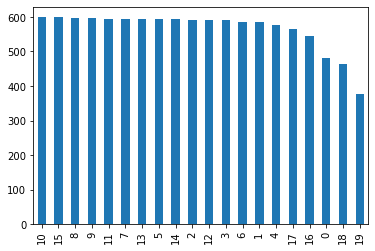

In [24]:
# 레이블 값의 분포를 시각화
data['target'].value_counts().plot(kind='bar');

In [25]:
# 데이터프레임으로부터 다시 메일 본문과 레이블을 분리
# 테스트 데이터 또한 불러오기
# 훈련 데이터와 테스트 데이터의 본문과 레이블을 각각 저장
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
train_email = data['email']
train_label = data['target']
test_email = newsdata_test.data
test_label = newsdata_test.target

- 케라스의 토크나이저 도구를 사용하여 전처리를 진행
- 필요한 변수들을 정의
    - vocab_size는 이번 실습에서 사용할 최대 단어 개수를 정의하는 변수
    - 빈도수 순으로 인덱스를 부여하므로, 빈도수가 가장 높은 상위 vocab_size 개수만큼의 단어를 사용

In [27]:
vocab_size = 10000
num_classes = 20

In [28]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
    tokenizer.fit_on_texts(train_data)
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    return X_train, X_test, tokenizer.index_word

In [32]:
train_label.nunique()

20

In [33]:
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

In [34]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [35]:
# 정수 인덱스는 1부터 시작하지만, 행렬의 인덱스는 0부터 시작하여 0번 인덱스는 사용되지 않으므로
# index_to_word[1] 확인
# 불용어에 해당되는 단어 'the'가 빈도수 상위 1번 단어가 된 것을 확인 가능
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


### 다층 퍼셉트론(Multilayer Perceptron, MLP)을 사용하여 텍스트 분류하기
- 모델을 설계

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [37]:
def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

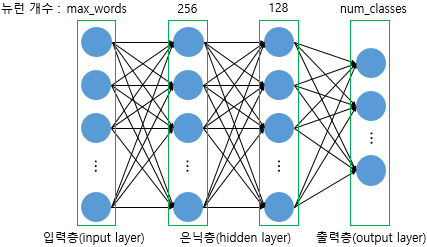

- 설계한 다층 퍼셉트론은 총 4개의 층을 가지고 있음
- vocab_size의 크기를 가진 입력층, 256개의 뉴런을 가진 첫번째 은닉층, 128개의 뉴런을 가진 두번째 은닉층, num_classes의 크기를 가진 출력층
- 은닉층이 2개이므로 깊은 신경망(Deep Neural Network, DNN)
- 과적합을 막기 위해서 두 번의 드롭아웃(Dropout)을 적용
- 다중 클래스 분류 문제
    - 다중 클래스 분류 문제이므로 출력층의 활성화 함수로는 소프트맥스 함수를 사용
    - 손실 함수로는 크로스 엔트로피(categorical_crossentropy) 함수를 사용

- 모델 훈련
    - texts_to_matrix()의 4개의 모드에 대해서 전부 모델의 결과를 확인
    - freq모드에서만 정확도가 낮음, 적절한 전처리 방법이 아님

In [38]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)

Epoch 1/5
80/80 [==============================] - 2s 18ms/step - loss: 2.3195 - accuracy: 0.3390 - val_loss: 0.9688 - val_accuracy: 0.8189
Epoch 2/5
80/80 [==============================] - 1s 16ms/step - loss: 0.8695 - accuracy: 0.7633 - val_loss: 0.4510 - val_accuracy: 0.8984
Epoch 3/5
80/80 [==============================] - 1s 15ms/step - loss: 0.4398 - accuracy: 0.8829 - val_loss: 0.3485 - val_accuracy: 0.8984
Epoch 4/5
80/80 [==============================] - 1s 16ms/step - loss: 0.2632 - accuracy: 0.9358 - val_loss: 0.2993 - val_accuracy: 0.9178
Epoch 5/5
80/80 [==============================] - 1s 16ms/step - loss: 0.1682 - accuracy: 0.9582 - val_loss: 0.2892 - val_accuracy: 0.9170
binary 모드의 테스트 정확도: 0.8289963006973267
Epoch 1/5
80/80 [==============================] - 2s 18ms/step - loss: 2.7903 - accuracy: 0.2475 - val_loss: 1.5767 - val_accuracy: 0.7491
Epoch 2/5
80/80 [==============================] - 1s 15ms/step - loss: 1.4621 - accuracy: 0.6289 - val_loss: 0.7301 - va